In [41]:
from qat.lang.AQASM import Program, H, CNOT, RX, RY, RZ, X, Z
import numpy as np
from qat.qpus import PyLinalg
from numpy import linalg
from qat.qpus import get_default_qpu
from qat.core import Observable, Term

# pyqubo imports
from pyqubo import Binary, Spin
from pprint import pprint
from dimod import ExactSolver

import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Hands-on: Problema da Mochila no VQE

## Descrição do problema

Imagine que voce tem uma mochila com capacidade $W$ (peso total) e barras de ouro de diversos pesos, $w_i$. Você quer colocar o máximo de ouro dentro da mochila, sem que sua capacidade seja ultrapassada. Quais barras de ouro colocar de forma a maximizar a quantidade de ouro dentro da mochila? Esta é uma versão simplificada do problema. Este exemplo pode ser generalizado para várias mochilas e objetos com valores e pesos diferentes.

<img src="mochila.jpeg" width=750 />

## Formulação como otimização irrestrita

Como queremos maximizar a quantidade de ouro dentro da mochila, podemos criar uma função objetivo de minimização da seguinte forma

$$H(\vec{x}) = \left(W - \sum_{i=0}^{n}w_ix_i\right)^2$$
onde $x_i=1$ se a barra de ouro $i$ está dentro da mochila e $x_i=0$ caso contrário. 





## Hands-on

Vamos fazer um exemplo simples, com poucas variáveis. Imagine que 3 clientes te pediram barras de um determinado material, cujos comprimentos são: Cliente 1 - `5m`; Cliente 2 - `3m`; e Cliente 3 - `1m`. No entando, você tem apenas uma barra com `6m`. Como cortar a barra de `6m` de forma a minimizar a sobra. Use o VQE para solucionar o problema.

### Exercício 1

Crie a função objetivo do problema usando o `Pyqubo`. Lembre-se de usar a classe `Binary("xi")` como suas variáveis binárias.

In [42]:
# -----------------------------
# criando a F.O. com pyqubo
# -----------------------------

# escreva seu codigo abaixo
num_variables = 3

W = 6
c0 = 5
c1 = 3
c2 = 1

#pedidos = [5,3,1]

H = (W - (c0*Binary("x0") + c1*Binary("x1") + c2*Binary("x2")))**2


# fim do seu codigo

# -----------------------------------
# Transformando de Binary para Ising
# -----------------------------------

model = H.compile()
model = model.to_ising()
linear, quadratic = model[0], model[1]

print("Termos lineares do modelo de Ising", linear)
print("Termos cruzados do modelo de Ising", quadratic)

Termos lineares do modelo de Ising {'x0': -4.0, 'x1': -7.0, 'x2': -9.0}
Termos cruzados do modelo de Ising {('x0', 'x1'): 14.0, ('x0', 'x2'): 18.0, ('x1', 'x2'): 31.5}


### Exercício 2

Escreva o modelo de Ising em termos de operadores de Pauli-Z. Crie um dicionário para armazenar cada termo da seguinte forma:

Exemplo: `hamiltonian = {"ZIZ": 4, ...}` onde as chaves são strings com operadores de Pauli-Z e Identidade e os respectivos valores são seus coeficientes.

In [43]:
# escreva o codigo abaixo
  
hamiltonian = {}
for key, value in linear.items():
    string = ''; z_index = int(key[1])
    for j in range(num_variables):
        if j != z_index: 
            string += 'I'
        elif j == z_index:
            string += 'Z'

    hamiltonian[string]=value

for key, value in quadratic.items():
    string = ''; z_indexes = [int(key[0][1]) , int(key[1][1])]
    for j in range(num_variables):
        if j not in z_indexes: 
            string += 'I'
        elif j == z_indexes[0]:
            string += 'Z'
        elif j == z_indexes[1]:
            string += 'Z'
    
    hamiltonian[string]=value
# fim do seu codigo

print(hamiltonian)

{'ZII': -4.0, 'IZI': -7.0, 'IIZ': -9.0, 'ZZI': 14.0, 'ZIZ': 18.0, 'IZZ': 31.5}


Agora, escreva o operador na forma matricial. Dica: crie as matrizes $Z$ e $I$ e use np.kron() para fazer o produto tensorial.

In [44]:
# Escreva seu codigo abaixo
z = np.matrix([[1,0],[0,-1]])
i = np.identity(2)

zii = np.kron(np.kron(z,i),i)
izi = np.kron(np.kron(i,z),i)
iiz = np.kron(np.kron(i,i),z)
zzi = np.kron(np.kron(z,z),i)
ziz = np.kron(np.kron(z,i),z)
izz = np.kron(np.kron(i,z),z)


h_matrix = -7.5*zii -4.5*izi -1.5*iiz + 7.5*zzi + 2.5*ziz + 1.5*izz

print(h_matrix)
# fim do seu codigo

[[ -2.   0.   0.   0.   0.   0.   0.   0.]
 [  0.  -7.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -11.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -10.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  -7.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  -2.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  14.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  25.]]


### Ansatz

O ansatz é um circuito quântico parametrizado. Sua forma variacional pode ser dada por padrões heurísticos geralmente implementada através de operadores de rotação e portas CNOT para realizar emaranhamento entre os qubits. Uma forma variacional eficiente é aquela capaz de generalizar bem um estado quântico, aumentando o espaço de busca. Podemos escrever a atuação do circuito variacional, $U(\vec{\theta})$, sobre um sistema com $n$ qubits de estado inicial, $|0\rangle^{\otimes n}$, como

$$U(\vec{\theta})|0\rangle^{\otimes n} = |\psi(\vec{\theta})\rangle$$

Agora, realizaremos o mesmo processo do exemplo anterios, mas agora não estaremos interessados em ter um número como solução, e sim um vetor, o $\vec{z}$. Embora minimizaremos o valor esperado de um operador, estaremos interessados no autoestado com maior probabilidade, associado ao menor valor esperado.

### Exercício 3

Aplique as operações no ansatz e defina, no lugar do `FIXME`, o numero de parametros variacionais que voce usou.

In [45]:
def ansatz(var_params):

    qprog = Program()
    qbits = qprog.qalloc(num_variables)

    # escreva seu codigo abaixo

    # cria um ansatz com 3 layers e 12 parametros
    qprog.apply(RX(var_params[0]),qbits[0])
    qprog.apply(RX(var_params[1]),qbits[1])
    qprog.apply(RX(var_params[2]),qbits[2])

    qprog.apply(RY(var_params[3]),qbits[0])
    qprog.apply(RY(var_params[4]),qbits[1])
    qprog.apply(RY(var_params[5]),qbits[2])

    qprog.apply(CNOT, qbits[0],qbits[1])
    qprog.apply(CNOT, qbits[0],qbits[2])
    qprog.apply(CNOT, qbits[1],qbits[2])

    qprog.apply(RX(var_params[6]),qbits[0])
    qprog.apply(RX(var_params[7]),qbits[1])
    qprog.apply(RX(var_params[8]),qbits[2])

    qprog.apply(RY(var_params[9]),qbits[0])
    qprog.apply(RY(var_params[10]),qbits[1])
    qprog.apply(RY(var_params[11]),qbits[2])

    qprog.apply(RX(var_params[12]),qbits[0])
    qprog.apply(RX(var_params[13]),qbits[1])
    qprog.apply(RX(var_params[14]),qbits[2])

    qprog.apply(RY(var_params[15]),qbits[0])
    qprog.apply(RY(var_params[16]),qbits[1])
    qprog.apply(RY(var_params[17]),qbits[2])
    # fim do seu codigo
  
    circ = qprog.to_circ()
    return circ

num_params = 18

circuit = ansatz([i for i in range(num_params)])
%qatdisplay circuit --svg

## Valor esperado do operador hamiltoniano

O valor esperado pode ser dado pelo valor médio das energias. O valor esperado é a função a ser minimizada e pode ser dado por

$$\langle \psi_\theta | H | \psi_\theta \rangle = \sum_{i} E_ip_i$$

### Exercício 4

Na função de calculo do valor esperado, defina os termos do Observável. Cada termo deve ser escrito como `Term(coeficiente, operador, [0,1,2])` e devem estar dentro da lista `pauli_terms`.

In [46]:
def expected_value(params):

    # chamando o ansatz
    circuit = ansatz(var_params = params)
    
    # criando o observavel
    # a classe Oservable é responsavel por realizar as medidas em diferentes bases
    # cada termo do observavel deve ser definido como Term(coeficiente, operador, [0,1,2]) 
    pauli_terms = [Term(value, key, [0,1,2]) for key, value in hamiltonian.items()]
    obs = Observable(3, pauli_terms = pauli_terms)
                                    
    # calcula o valor esperado do observavel para um conjunto de parametros
    job = circuit.to_job(observable=obs, nbshots=1000)
    result = get_default_qpu().submit(job)
    print(" CUSTO: \t ", result.value)
    conv.append(result.value)

    return result.value

def run_vqe_comb():

    res = scipy.optimize.minimize(expected_value, x0=np.ones(num_params), 
                                method = 'COBYLA', callback=None,
                                options={'maxiter': 500, 'ftol': 1e-06, 'iprint': 20, 'disp': True, 
                                'eps': 1.4901161193847656e-08, 'finite_diff_rel_step': None})

    print("\n" , 100*"-",  "\n Aproximação da Energia Fundamental: \t ", res['fun'], "\n", 100*"-")
    print("\n Parametros ótimos do circuito varicional: \t ", res['x'])

    return res['x'], conv

conv = []
best_params, conv = run_vqe_comb()

 CUSTO: 	  -0.45623690519673854
 CUSTO: 	  -6.4421094014302005
 CUSTO: 	  -17.68544302598898
 CUSTO: 	  -13.025879641349988
 CUSTO: 	  -17.643465987092863
 CUSTO: 	  -17.11332316013641
 CUSTO: 	  -14.068022118184373
 CUSTO: 	  -12.134487371677906
 CUSTO: 	  -14.721529254356136
 CUSTO: 	  -10.588084619885892
 CUSTO: 	  -16.091018479289946
 CUSTO: 	  7.704353366294585
 CUSTO: 	  -19.52124527317786
 CUSTO: 	  -18.510305768215375
 CUSTO: 	  -7.660809186177147
 CUSTO: 	  -18.582526348489395
 CUSTO: 	  -13.233091232581854
 CUSTO: 	  -8.28532519317573
 CUSTO: 	  -9.095267334319285
 CUSTO: 	  -17.213300501128444
 CUSTO: 	  -17.904225169152014
 CUSTO: 	  -19.62715179452086
 CUSTO: 	  -24.304774751639336
 CUSTO: 	  -23.43505261577455
 CUSTO: 	  -23.13789658929915
 CUSTO: 	  -24.20701928563491
 CUSTO: 	  -23.495884898655454
 CUSTO: 	  -24.811221729044764
 CUSTO: 	  -24.527450551630714
 CUSTO: 	  -23.32936001658613
 CUSTO: 	  -24.7929750931774
 CUSTO: 	  -21.0570281741016
 CUSTO: 	  -24.4957702877

### Exercicio 5

Pegue os melhores parametros encontrados na minimização do valor esperado e aplique-os no ansatz. Este circuito será o circuito "ótimo" e medidas neste circuito nos dará informações sobre as melhores soluções.

In [47]:
# corrija os FIXMEs aqui
best_circuit = ansatz(best_params)
job = best_circuit.to_job()
# fim do exercicio

result = get_default_qpu().submit(job)

states, probs = [], []
for sample in result:
    print(f"Estado:  {sample.state} \t Probabilidade:  {sample.probability}")
    states.append(sample.state)
    probs.append(sample.probability)

print(f" \n \n Autoestado com maior ocorrência:  {str(states[probs.index(max(probs))])} \t Probabilidade:  {max(probs)}")

Estado:  |000> 	 Probabilidade:  2.325969453055458e-06
Estado:  |001> 	 Probabilidade:  0.4999987210401045
Estado:  |010> 	 Probabilidade:  0.038363301852579676
Estado:  |011> 	 Probabilidade:  2.039407301351739e-06
Estado:  |100> 	 Probabilidade:  1.3184284199849083e-06
Estado:  |101> 	 Probabilidade:  9.141704329253881e-07
Estado:  |110> 	 Probabilidade:  0.4616306970902061
Estado:  |111> 	 Probabilidade:  6.820415030215008e-07
 
 
 Autoestado com maior ocorrência:  |001> 	 Probabilidade:  0.4999987210401045


O autoestado com maior ocorrência indica a solução ótima.

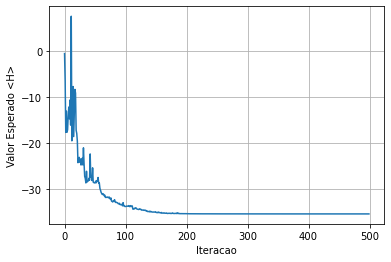

In [48]:
plt.plot(conv)
plt.xlabel("Iteracao")
plt.ylabel("Valor Esperado <H>")
plt.grid()